### Atividade -- Data Augmentation

Aluno: Lucas Elias de Andrade Cruvinel

Matricula: 20232011270241

Modelos Utilizados: Rotation e Flips

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shutil
from dataclasses import dataclass
import tensorflow as tf

import keras
from tensorflow.data import Dataset
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, InputLayer, RandomFlip, RandomRotation, Rescaling
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from keras.utils import image_dataset_from_directory

2024-04-19 23:48:46.170088: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 23:48:46.170137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 23:48:46.171651: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-19 23:48:46.179803: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(keras.__version__)
print(tf.__version__)

2.15.0
2.15.0


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-04-19 23:48:48.265515: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-19 23:48:48.276478: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-19 23:48:48.279584: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
quant_labels=10
labels = ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']

In [5]:
print("Train e Validation:")
trainDS, validDS = image_dataset_from_directory(
    directory="bd/train",
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=42,
    validation_split=0.15,
    subset="both",
    interpolation="bilinear",
)
print("\nTest:")
testDS = image_dataset_from_directory(
    directory="bd/test",
    labels="inferred",
    label_mode="categorical",
    image_size=(128, 128),
    shuffle=False,
    interpolation="bilinear",
)

Train e Validation:
Found 7500 files belonging to 10 classes.
Using 6375 files for training.
Using 1125 files for validation.


2024-04-19 23:48:48.909027: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-19 23:48:48.912846: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-19 23:48:48.915733: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-


Test:
Found 2500 files belonging to 10 classes.


In [6]:
def create_prof_model(quant_labels, nome="Exemplo",  flip=False, rotation=False):
    model = Sequential(name=nome)

    #### Input Layer ####
    model.add(InputLayer(input_shape=(128, 128, 3)))
    model.add(Rescaling(1./255))
    if flip:
        model.add(RandomFlip("horizontal_and_vertical"))

    if rotation:
        model.add(RandomRotation(0.2))

    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))

    #### Convolutional Layers ####
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))  # Pooling
    model.add(Dropout(0.2)) # Dropout

    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(512, (5,5), padding='same', activation='relu'))
    model.add(Conv2D(512, (5,5), activation='relu'))
    model.add(MaxPooling2D((4,4)))
    model.add(Dropout(0.2))

    #### Fully-Connected Layer ####
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(quant_labels, activation='softmax'))

    return model
    
model = create_prof_model(quant_labels, flip=True, rotation=True)
model.summary() # a handy way to inspect the architecture

Model: "Exemplo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 128, 128, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 128, 128, 3)       0         
 ation)                                                          
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                        

In [7]:
def run_model(batch_size, n_epochs, optimizer, checkpoint_filepath, nome, flip=False, rotation=False):
    trainDS, validDS = image_dataset_from_directory(
        directory="bd/train",
        labels="inferred",
        label_mode="categorical",
        batch_size=batch_size,
        image_size=(128, 128),
        shuffle=True,
        seed=42,
        validation_split=0.15,
        subset="both",
        interpolation="bilinear",
        )

    model = create_prof_model(quant_labels, nome, flip=flip, rotation=rotation)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Saves Keras model after each epoch
    checkpointer = ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_best_only=True)

    # Early stopping to prevent overtraining and to ensure decreasing validation loss
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

    history = model.fit(
        trainDS,
        epochs=n_epochs,
        validation_data=validDS,
        callbacks=[
            early_stop, 
            checkpointer, 
            # PlotLossesKeras()
            ],
        verbose=True)
    return history

In [8]:
@dataclass
class model_data:
    model: str
    labels: list()
    hist: None = None
    y_pred: None = None
    cm: None = None
    report: None = None

    def get_weight_path(self):
        return f"pesos/food_model_{self.model}.weights.keras"

    def execute_model(self, batch_size, n_epochs, flip=False, rotation=False):
        self.hist = run_model(
            batch_size,
            n_epochs,
            optimizer=RMSprop(learning_rate=0.0001), 
            checkpoint_filepath = self.get_weight_path(),
            nome=self.model, 
            flip=flip, 
            rotation=rotation
        )

    def execute_prediction(self, testDS):
        model = load_model(self.get_weight_path())
        predict = model.predict(testDS)
        self.y_pred = np.argmax(predict, axis=-1)
        y_true = np.argmax(np.concatenate([y for x, y in testDS], axis=0), axis=1)
        self.cm = confusion_matrix(y_true, self.y_pred)
        self.report = classification_report(y_true, self.y_pred,target_names=self.labels, output_dict=True, zero_division=0.0)

models_data = {k: model_data(k, labels) for k in ["padrao", "flip", "rotation", "flip_and_rotation"]}

BATCH_SIZE = 64
N_EPOCHS = 60

In [9]:
models_data["padrao"].execute_model(BATCH_SIZE, N_EPOCHS, flip=False, rotation=False)

Found 7500 files belonging to 10 classes.
Using 6375 files for training.
Using 1125 files for validation.
Epoch 1/60


2024-04-19 23:48:53.119723: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inpadrao/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-19 23:48:53.664570: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-19 23:48:57.816609: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fcdf00862f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-19 23:48:57.816650: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-04-19 23:48:57.823728: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1713570537.899788   11778 device_compiler.h:186] Compiled cluster using XLA!  This line is 

100/100 [==============================] - ETA: 0s - loss: 2.2933 - accuracy: 0.1187
Epoch 1: val_loss improved from inf to 2.24989, saving model to pesos/food_model_padrao.weights.keras
100/100 [==============================] - 50s 391ms/step - loss: 2.2933 - accuracy: 0.1187 - val_loss: 2.2499 - val_accuracy: 0.1796
Epoch 2/60
100/100 [==============================] - ETA: 0s - loss: 2.1804 - accuracy: 0.1958
Epoch 2: val_loss improved from 2.24989 to 2.09943, saving model to pesos/food_model_padrao.weights.keras
100/100 [==============================] - 16s 153ms/step - loss: 2.1804 - accuracy: 0.1958 - val_loss: 2.0994 - val_accuracy: 0.2293
Epoch 3/60
100/100 [==============================] - ETA: 0s - loss: 2.0784 - accuracy: 0.2334
Epoch 3: val_loss improved from 2.09943 to 2.04776, saving model to pesos/food_model_padrao.weights.keras
100/100 [==============================] - 16s 155ms/step - loss: 2.0784 - accuracy: 0.2334 - val_loss: 2.0478 - val_accuracy: 0.2702
Epoch 4

In [10]:
models_data["flip"].execute_model(BATCH_SIZE, N_EPOCHS, flip=True, rotation=False)

Found 7500 files belonging to 10 classes.
Using 6375 files for training.
Using 1125 files for validation.
Epoch 1/60


2024-04-19 23:56:46.184040: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inflip/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - ETA: 0s - loss: 2.2963 - accuracy: 0.1181
Epoch 1: val_loss improved from inf to 2.26084, saving model to pesos/food_model_flip.weights.keras
100/100 [==============================] - 18s 163ms/step - loss: 2.2963 - accuracy: 0.1181 - val_loss: 2.2608 - val_accuracy: 0.1484
Epoch 2/60
100/100 [==============================] - ETA: 0s - loss: 2.1881 - accuracy: 0.1843
Epoch 2: val_loss improved from 2.26084 to 2.08936, saving model to pesos/food_model_flip.weights.keras
100/100 [==============================] - 17s 165ms/step - loss: 2.1881 - accuracy: 0.1843 - val_loss: 2.0894 - val_accuracy: 0.2267
Epoch 3/60
100/100 [==============================] - ETA: 0s - loss: 2.0847 - accuracy: 0.2287
Epoch 3: val_loss improved from 2.08936 to 2.03314, saving model to pesos/food_model_flip.weights.keras
100/100 [==============================] - 17s 165ms/step - loss: 2.0847 - accuracy: 0.2287 - val_loss: 2.0331 - val_accuracy: 0.2560
Epoch 4/60
10

In [11]:
models_data["rotation"].execute_model(BATCH_SIZE, N_EPOCHS, flip=False, rotation=True)

Found 7500 files belonging to 10 classes.
Using 6375 files for training.
Using 1125 files for validation.
Epoch 1/60


2024-04-20 00:09:00.267963: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inrotation/dropout_15/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - ETA: 0s - loss: 2.2839 - accuracy: 0.1302
Epoch 1: val_loss improved from inf to 2.20185, saving model to pesos/food_model_rotation.weights.keras
100/100 [==============================] - 18s 160ms/step - loss: 2.2839 - accuracy: 0.1302 - val_loss: 2.2018 - val_accuracy: 0.2151
Epoch 2/60
100/100 [==============================] - ETA: 0s - loss: 2.1929 - accuracy: 0.1914
Epoch 2: val_loss improved from 2.20185 to 2.12967, saving model to pesos/food_model_rotation.weights.keras
100/100 [==============================] - 17s 164ms/step - loss: 2.1929 - accuracy: 0.1914 - val_loss: 2.1297 - val_accuracy: 0.2453
Epoch 3/60
100/100 [==============================] - ETA: 0s - loss: 2.1171 - accuracy: 0.2267
Epoch 3: val_loss improved from 2.12967 to 2.08768, saving model to pesos/food_model_rotation.weights.keras
100/100 [==============================] - 17s 166ms/step - loss: 2.1171 - accuracy: 0.2267 - val_loss: 2.0877 - val_accuracy: 0.2604
E

In [12]:
models_data["flip_and_rotation"].execute_model(BATCH_SIZE, N_EPOCHS, flip=True, rotation=True)

Found 7500 files belonging to 10 classes.
Using 6375 files for training.
Using 1125 files for validation.
Epoch 1/60


2024-04-20 00:20:20.913296: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inflip_and_rotation/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - ETA: 0s - loss: 2.2878 - accuracy: 0.1293
Epoch 1: val_loss improved from inf to 2.20645, saving model to pesos/food_model_flip_and_rotation.weights.keras
100/100 [==============================] - 19s 162ms/step - loss: 2.2878 - accuracy: 0.1293 - val_loss: 2.2064 - val_accuracy: 0.2027
Epoch 2/60
100/100 [==============================] - ETA: 0s - loss: 2.1865 - accuracy: 0.1885
Epoch 2: val_loss improved from 2.20645 to 2.11115, saving model to pesos/food_model_flip_and_rotation.weights.keras
100/100 [==============================] - 17s 165ms/step - loss: 2.1865 - accuracy: 0.1885 - val_loss: 2.1112 - val_accuracy: 0.2213
Epoch 3/60
100/100 [==============================] - ETA: 0s - loss: 2.1031 - accuracy: 0.2301
Epoch 3: val_loss improved from 2.11115 to 2.06017, saving model to pesos/food_model_flip_and_rotation.weights.keras
100/100 [==============================] - 17s 164ms/step - loss: 2.1031 - accuracy: 0.2301 - val_loss: 2.06

In [13]:
for k, i in models_data.items():
    print(k)
    i.execute_prediction(testDS)


padrao
79/79 [==============================] - 5s 41ms/step
flip
79/79 [==============================] - 2s 22ms/step
rotation
79/79 [==============================] - 2s 23ms/step
flip_and_rotation
79/79 [==============================] - 2s 28ms/step


[]

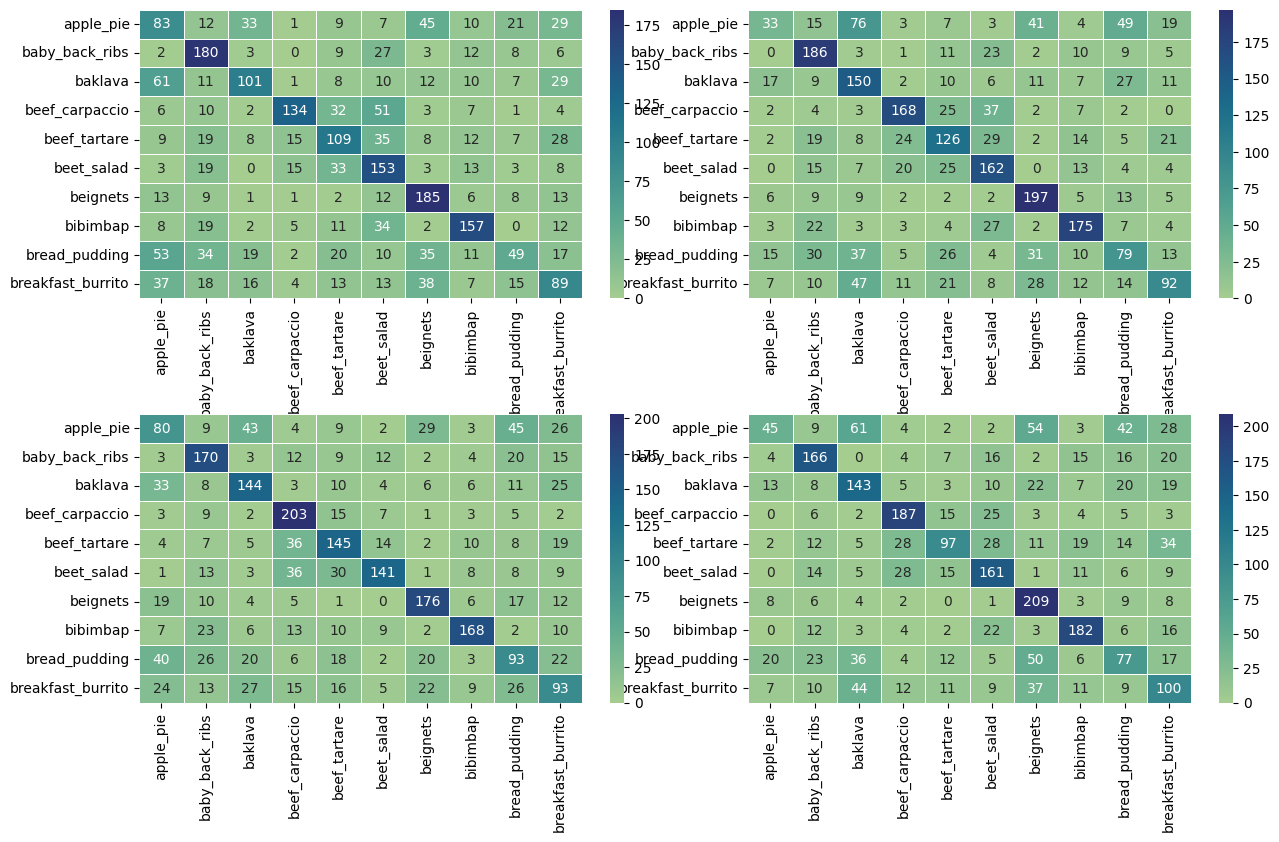

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 9))

for ind, elem in enumerate(models_data.values()):
    i, j = divmod(ind, 2)
    sns.heatmap(elem.cm, ax=axes[i, j], annot=True, fmt="d", linewidth=.5, cmap="crest", xticklabels=labels, yticklabels=labels)

plt.subplots_adjust(wspace=0.1, hspace=0.4)
plt.savefig("confusion_matrix.png")
plt.plot()

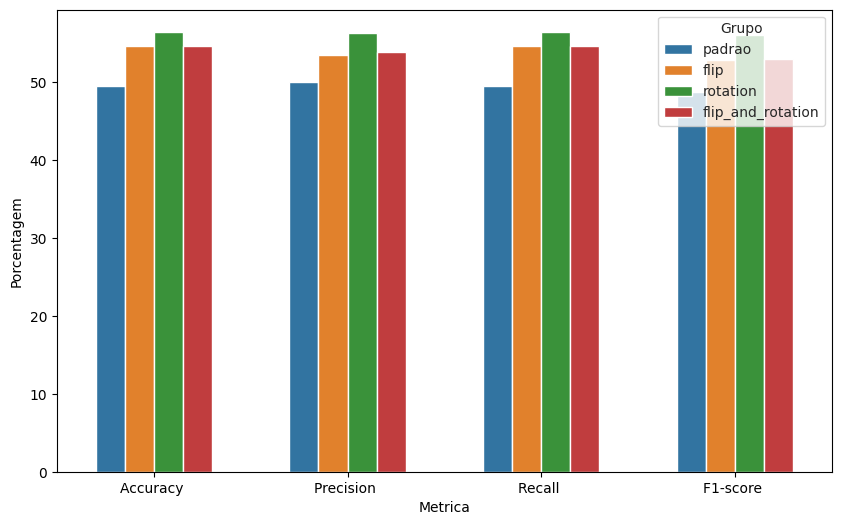

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
data = []
for ind, elem in enumerate(models_data.values()):
    data.append([elem.model, "Accuracy ", elem.report["accuracy"]*100.0])
    data.append([elem.model, "Precision ", elem.report["macro avg"]["precision"]*100.0])
    data.append([elem.model, "Recall ", elem.report["macro avg"]["recall"]*100.0])
    data.append([elem.model, "F1-score ", elem.report["macro avg"]["f1-score"]*100.0])

df = pd.DataFrame(data, columns=['Grupo', 'Metrica', 'Porcentagem'])
# ax.grid()
sns.set_style("ticks",{'axes.grid' : True})
sns.barplot(data=df, ax=ax, x='Metrica', y='Porcentagem', hue='Grupo', width=0.6)
plt.savefig("barplot.png")
plt.show()

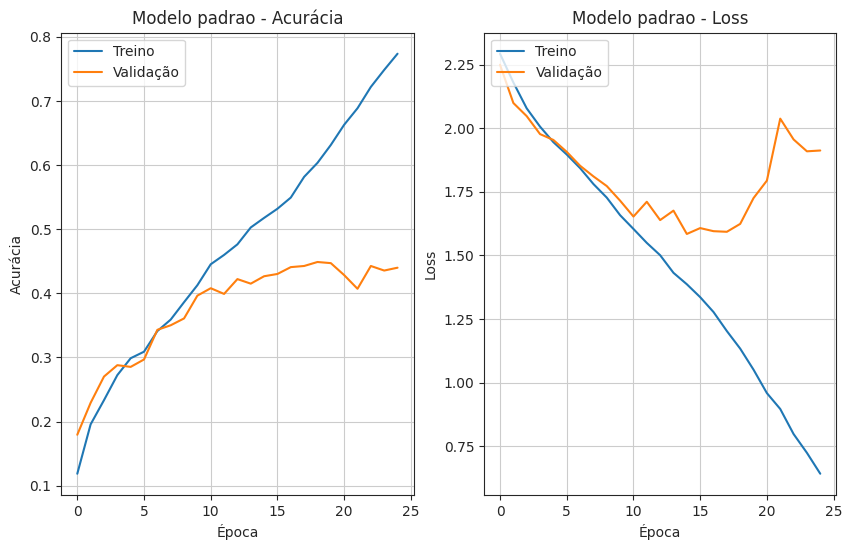

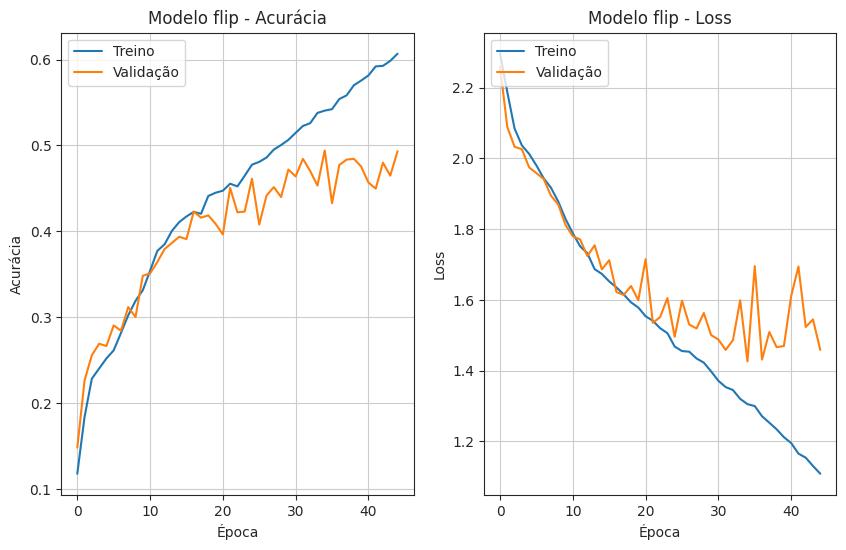

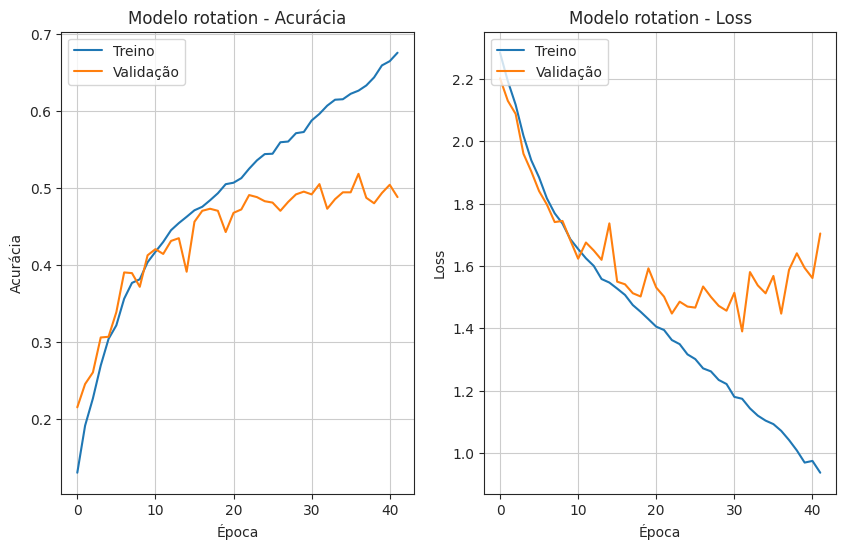

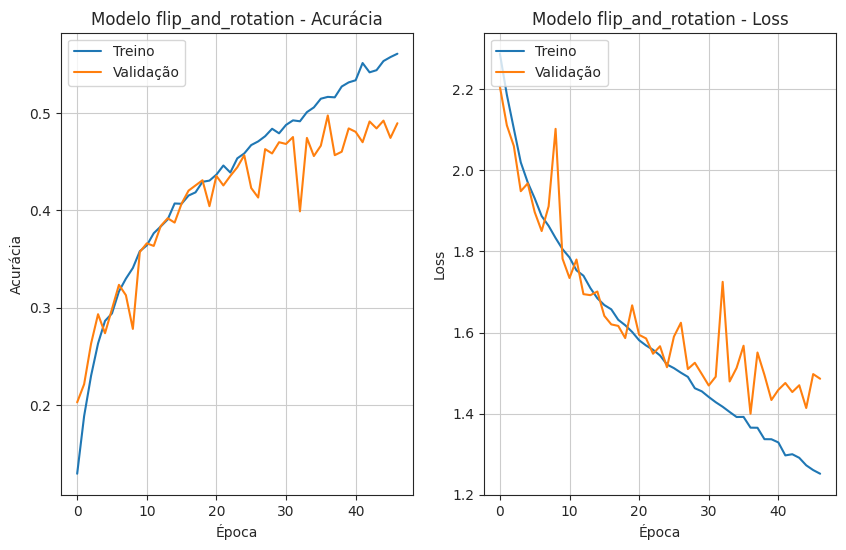

In [16]:
for ind, elem in enumerate(models_data.values()):
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
    axes[0].plot(elem.hist.history['accuracy'])
    axes[0].plot(elem.hist.history['val_accuracy'])
    axes[0].set_title(f'Modelo {elem.model} - Acurácia')
    axes[0].set_ylabel('Acurácia')
    axes[0].set_xlabel('Época')
    axes[0].legend(['Treino', 'Validação'], loc='upper left')

    axes[1].plot(elem.hist.history['loss'])
    axes[1].plot(elem.hist.history['val_loss'])
    axes[1].set_title(f'Modelo {elem.model} - Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Época')
    axes[1].legend(['Treino', 'Validação'], loc='upper left')

    plt.savefig(f"hist_{elem.model}.png")
    plt.show()